# 📜 Exploration 10. 뉴스 요약봇 만들기 📜

## 📝 진행 순서 📝
1. 프로젝트 수행에 필요한 필수 개념
2. 데이터 준비하기
3. 데이터 전처리 하기 (Abstractive Summarization)
4. 모델 설계하고 훈련하기 (Abstractive Summarization)
5. 인퍼런스 모델 구현하고 테스트하기 (Abstractive Summarization)
6. Summa를 이용하여 요약하기 (Extractive Summarization)
7. 추상적 요약과 추출적 요약의 결과 비교 분석
8. 탐험을 마치며

## 📒 1. 프로젝트 수행에 필요한 필수 개념 📒

### 1) 텍스트 요약

- **텍스트 요약(Text Summarization)** : 긴 길이의 문서 원문을 핵심 주제만으로 구성된 짧은 Summary 문장의 형태로 변환하는 기법
- **텍스트 요약 작업은 원문의 길이가 길수록 어려워진다.** 그 이유는 기본 데이터 size가 커지는 데다 정확하게 읽고 이해한 뒤에 번역을 해야 하는 부분이 있기 때문이다.
- 텍스트 요약은 크게 **추출적 요약(Extractive Summarization)**과 **추상적 요약(Abstractive Summarization)**으로 나눌 수 있다.
- **추출적 요약(Extractive Summarization)** : 단어 그대로 원문에서 문장들을 추출해서 요약하는 방법 (Text Classification)
- **추상적 요약(Abstractive Summarization)** : 원문으로부터 내용이 요약된 새로운 문장을 생성하는 방법 (자연어 처리 → NLG)

### 2) seq2seq

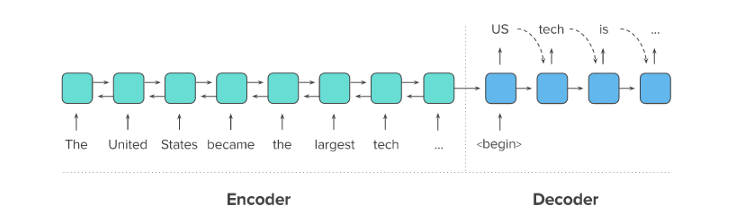

- Google이 메일 서비스에 적용한 자동회신 기능을 만든 것과 비슷한 딥러닝 기법
- 2개의 RNN Architecture를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해내는 자연어 생성 모델
- 인코더와 디코더의 구조로 구성
- 원문을 첫 번째 RNN인 Encoder로 입력하면, Encoder는 이를 벡터로 변환한다. 이 벡터는 문맥 정보를 가지고 있는 **컨텍스트 벡터**라고 한다.
- 컨텍스트 벡터는 인코더의 hidden state의 중요도를 취합한 것이다.
- 두 번째 RNN인 Decoder는 컨텍스트 벡터를 전달받아 한 단어씩 생성해내서 요약문을 완성한다.
- seq2seq를 구현하기 위해 **LSTM(Long Short Term Memory)**를 사용한다.
- LSTM은 일반적인 바닐라 RNN과는 달리, hidden state와 함께 **cell state도 전달한다.**

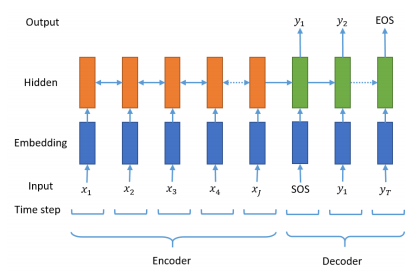

- seq2seq 구조에서 디코더는 시작 토큰인 SOS가 입력되면 종료 토큰인 EOS를 예측하는 순간까지 멈추지 않고 동작한다.
- 따라서 전처리 과정에서 시작 토큰과 종료 토큰을 통해 어디서 시작하고 멈춰야 하는지를 Guiding 해준다.

### 3) Attention Mechanism

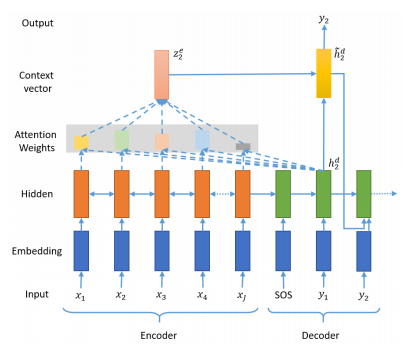

- 기존 seq2seq를 수정하고 새로운 모듈을 추가하여 모델의 성능을 높이는 데 사용
- **기존 seq2seq** : 인코더의 **마지막 time step**의 hidden state를 컨텍스트 벡터에 반영하고, 디코더의 현재 스텝 위치에 관계없이 컨텍스트 벡터가 한 번 계산되면 그 값이 고정값으로 간주된다.
- **Attention Mechanism** : 인코더의 **모든 step**의 hidden state를 컨텍스트 벡터에 반영하고, 디코더의 현재 스텝이 어딘지에 따라서 인코더 hidden state의 가중치 값이 계속 변한다.
- 이 과정에 의해 계산된 컨텍스트 벡터를 이용해서 디코더는 다음에 등장할 단어를 예측하게 된다.

## 📘 2. 데이터 준비하기 📘

- NLTK 패키지를 import 하고 불용어 사전을 다운 받는다.

In [1]:
import nltk
nltk.download('stopwords')

print('불용어 사전 다운로드 완료')

불용어 사전 다운로드 완료


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- 기타 프로젝트 수행에 필요한 패키지를 불러온다.

In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('패키지 불러오기 완료')

패키지 불러오기 완료


- 데이터는 링크를 따라 이동하면 나오는 **news_summary_more.csv** 파일을 사용할 것이다. (https://github.com/sunnysai12345/News_Summary)
- 아래 코드를 입력하여 csv 데이터를 다운로드할 수 있다.

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

- **data.head()** : 전체 데이터의 0번 인덱스 데이터부터 5개까지 보여준다. 괄호 안에 숫자를 넣으면 그 숫자만큼 보여준다.
- **data.sample()** : 전체 데이터 중 랜덤하게 1개의 데이터 row를 보여준다. 괄호 안에 숫자를 넣으면 그 숫자만큼 랜덤하게 보여준다.
- 아래 데이터는 기사의 본문에 들어가는 headlines와 text 두 개의 column으로 구성되어 있다.
- 여기서 **text는 본문**, **headlines는 이미 요약된 데이터**라고 생각하겠다.
- 추상적 요약에서는 text와 headlines를 모두 활용하여 모델을 학습시킬 수 있다.
- 추출적 요약에서는 text 열만을 사용한다. 원문에서 문장들을 추출하여 요약하여야 하기 때문이다.

In [4]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [5]:
data.sample(5)

,headlines,text
76202,Thailand sentences man to 18 yrs for insulting...,A Thai national has been sentenced to 18 years...
2891,Thought it was prank: Deepika on featuring in ...,"Actress Deepika Padukone, while speaking on fe..."
92408,SEBI court quashes non-bailable warrant agains...,A special Securities and Exchange Board of Ind...
42990,Thane man fined Ã¢ÂÂ¹60.24 lakh for destroyin...,A landowner in Thane has been imposed with a f...
65413,IBM launches blockchain banking for cross-bord...,US technology company IBM has launched blockch...


## 📕 3. 데이터 전처리 하기 (Abstractive Summarization) 📕

### 1) 중복, 결측치 제거

- 우선, 시작하기 전에 nunique 메서드가 무엇인지 살펴보는 것도 좋겠다. (https://blog.naver.com/ahw_0703/222265006003)

In [6]:
print('text 열에서 중복을 배제한 유일한 샘플의 수는', data['text'].nunique(), '개 입니다!')
print('headlines 열에서 중복을 배제한 유일한 샘플의 수는', data['headlines'].nunique(), '개 입니다!')

text 열에서 중복을 배제한 유일한 샘플의 수는 98360 개 입니다!
headlines 열에서 중복을 배제한 유일한 샘플의 수는 98280 개 입니다!


- **text 자체가 중복되는 경우**에는 중복 데이터로 간주하고 제거해 준다.
- **drop_duplicates()** 메서드를 이용하여 중복 샘플을 쉽게 제거해 준다.

In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾼다.
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 text 샘플의 수는', (len(data)), '개 입니다!')

전체 text 샘플의 수는 98360 개 입니다!


- 혹시 Null 값이 남아있지는 않은지 **.isnull().sum()** 메서드로 확인한다.
- 다행스럽게도 **Null 값은 없었다!**
- Null 값이 존재한다면 dropna() 메서드를 이용하면 되지만, Null 값이 존재하지 않으므로 넘어간다.

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 2) 텍스트 정규화

- 텍스트 정규화를 위한 사전을 구성한다. 정규화 사전은 아래 링크를 참조하였다.
(https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수는", len(contractions), "개 입니다!")

정규화 사전의 수는 120 개 입니다!


### 3) 불용어 제거

- 불용어는 stopwords라고 불린다.
- 일반적인 텍스트에서 자주 볼 수 있으나 **자연어 처리에서 별로 도움이 되지 않는 단어**를 말한다.
- 자연어 처리의 성능을 높이기 위해서는 불용어를 제거해 주는 것이 도움이 된다.
- NLTK에서 제공하는 stopwords 리스트를 참조해 샘플 내의 불용어를 제거한다.

In [10]:
print('english 불용어 개수는', len(stopwords.words('english')), '개 입니다!')
print(stopwords.words('english'))

english 불용어 개수는 179 개 입니다!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'ow

- 정말 필요한 내용만 잘 학습할 수 있도록 몇몇 제약조건 하에서 전처리하는 함수를 정의한다.

In [11]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거(text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거(headlines) - 상대적으로 문장의 길이가 짧으므로 Abstractive한 문장 요약 결과문이 자연스럽도록!
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

- 정의된 전처리 함수가 잘 돌아가는지 확인해보기 위해 임의의 text와 summary를 만들고 함수를 호출한다.
- 위에서 정의된 sentence 정제 규칙을 적용해 아래와 같이 전처리할 수 있다.
- 전처리 테스트를 위해 사용한 텍스트는 **K/DA - POP/STARS 가사의 일부를 활용했다.**
(https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=1&ie=utf8&query=k%2Fda+pop+stars)
- temp_text에 불용어가 그렇게나 많았던가..(😅)

In [12]:
# 전처리 하기 전 텍스트
temp_text = 'We gotta it all in our hands now So can you handle what we are all about'
temp_summary = 'We POP/STARS'

# 전처리 결과 확인
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않는다.

gotta hands handle
we pop stars


- 어쨌든.. 함수가 문제없이 돌아감을 확인했으니 이제 훈련 데이터 전체에 대한 전처리를 실행한다.
- **훈련 데이터 전체를 활용하므로** 싱글 프로세스로는 전처리 결과가 나오는 데 적지 않은 시간을 소모하게 된다.
- 따라서 노드에서 소개한 **멀티 프로세싱 기법을 사용하여 전처리를 수행**할 것이다.

In [13]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄이자.
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣는다.

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환 한다.
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구한다.

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 한다.
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 작업한 데이터를 하나로 합친다.
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False)   # 불용어를 제거하지 않는다.
print(clean_headlines)

184.12444972991943  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

- 데이터를 정제하는 과정에서 문장을 이루는 모든 단어가 사라질 수도 있다.
- 이를 확인해보기 위해 다시 한 번 empty한 샘플을 확인해볼 필요가 있다.
- 빈 값을 Null 값으로 대체한다.

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

- Null 값으로 몇 개나 변환되는지 확인해보기 위해 **.isnull.sum()**을 활용한다.
- 정제 후 모든 단어가 제거되어 빈 값으로 간주된 데이터가 없었다!

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 4) 훈련 데이터와 테스트 데이터 나누기 Part. I

- 학습을 위해 사용할 데이터의 크기를 결정하고 문장의 시작과 끝을 표시해 준다.
- 우선 text와 headlines에 대한 최소, 최대, 평균 길이를 출력하고, 시각화한다.
- 많은 양의 데이터를 다루므로 데이터 시각화가 도움이 된다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


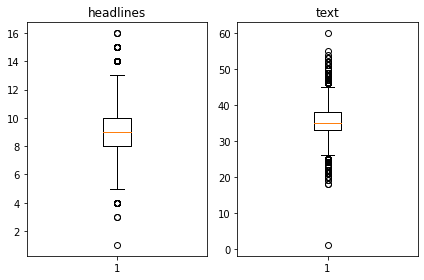

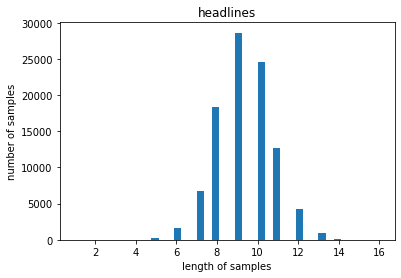

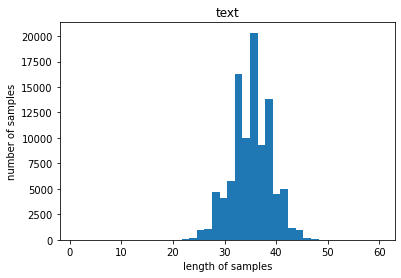

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

# 길이 분포 시각화
plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- text와 headlines에 대한 적절한 최대 길이를 임의로 설정한다.

In [17]:
text_max_len = 40
headlines_max_len = 10

- 저는 각각 40과 10으로 결정했는데, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 확인해보기 위해 아래와 같이 함수를 정의한다.
- 아래 함수는 훈련 데이터와 샘플의 길이를 입력하면 데이터의 몇 %가 해당하는지 계산해준다.

In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

- 만든 함수를 text와 headlines에 적용해 결정한 임의의 길이가 몇 %의 샘플까지 포함하는지 확인해 본다.

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


- 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제한다.

In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플 수 :', (len(data)))

전체 샘플 수 : 74102


### 5) 시작 토큰과 종료 토큰

- 시작 토큰과 종료 토큰은 **새로운 문장을 생성하는 쪽에 해당**하므로, headlines 데이터를 활용한다.

In [21]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


- 인코더, 디코더의 입력과 레이블을 다시 Numpy 타입으로 저장한다.

In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 6) 훈련 데이터와 테스트 데이터 나누기 Part. II

- encoder_input와 크기와 shape가 같은 순서가 섞인 정수형 시퀀스를 만든다.

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[45928 37506 13860 ... 48092   745 39035]


- 만들어 둔 정수형 시퀀스를 이용해 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 된다.

In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

- **훈련 데이터 (8) : 테스트 데이터(2)** 의 비율로 분리한다. (보통 테스트 데이터는 20% 수준으로 설정한다!)

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)   # 전체 샘플 수의 약 20%

테스트 데이터의 수 : 14820


- 이렇게 정의한 테스트 데이터의 개수를 이용해서 전체 데이터를 양분한다.
- 출력해 보면 훈련 데이터와 레이블은 59282개, 테스트 데이터와 레이블은 14820개로 정상적으로 분리되었다.

In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


### 7) 정수 인코딩

- Keras의 Tokenizer를 사용하여 입력된 훈련 데이터로부터 단어 집합을 만든다.

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

- 등장 빈도 수가 6회 미만 즉, 5회 이하인 단어들이 이 데이터에서 비중을 얼마나 차지하는지 확인한다.
- 등장 빈도 수가 6회 미만 즉, 5회 이하인 단어들은 전체 단어 집합에서 65%를 차지함을 알 수 있다.
- 그러나, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 약 3.7%였다.

In [29]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61614
등장 빈도가 5번 이하인 희귀 단어의 수: 40587
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21027
단어 집합에서 희귀 단어의 비율: 65.87301587301587
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.699157980695167


- 이제 등장 빈도 수가 5회 이하인 단어들을 이후 진행될 정수 인코딩 과정에서 제외하고, 훈련 데이터에서도 제거한다.
- Tokenizer를 정의할 때 단어의 수(num_words)를 정해주면 단어 집합의 크기를 제한할 수 있다.

In [30]:
src_vocab = 7500
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 7,500으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

- **texts_to_sequences()** : 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 인코딩을 수행하는 메서드
- 실행 결과, 정수형 시퀀스 형태로 잘 출력되는 것을 확인할 수 있다.

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[57, 11, 6527, 682, 66, 4392, 2575, 274, 30, 7348, 2596, 2549, 102, 605, 253, 18, 30, 2596, 4754, 1252, 11, 4012, 7, 1, 274, 138, 1, 75, 57, 274], [1074, 1555, 135, 2023, 309, 6, 994, 527, 528, 1075, 278, 42, 29, 612, 4336, 750, 2536, 2492, 36, 2773, 29, 5, 78, 488, 758, 4663], [1211, 3, 2688, 1093, 43, 6, 469, 19, 1631, 4579, 1, 3, 123, 3137, 154, 1091, 22, 1754, 2137, 4337, 1564, 215, 4, 7112, 3, 2445, 3342, 2137, 890, 285, 232, 950, 415, 339]]


- 같은 작업을 decoder에 해당하는 headlines에도 수행한다.

In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

- headlines의 경우 문장의 길이가 text보다 대체로 짧게 이루어져 있다.
- 따라서 등장 빈도수가 5회 미만 즉, 4회 이하인 단어들이 이 데이터에서 얼마나 비중을 차지하는지 확인한다.
- 확인 결과, 등장 빈도수가 5회 미만 즉, 4회 이하인 단어의 비중은 약 62.94% 정도가 나왔다.

In [33]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27328
등장 빈도가 4번 이하인 희귀 단어의 수: 17202
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10126
단어 집합에서 희귀 단어의 비율: 62.94642857142857
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.07040851868438


- 하지만 decoder의 훈련 데이터에서 등장 빈도로 차지하는 비중은 5.07% 정도였다.
- encoder 작업 때와 동일하게 정수 인코딩 과정에서 제외하고, 훈련 데이터에서도 제거한다.
- 단어 집합의 크기는 1700으로 제한한다.

In [34]:
tar_vocab = 1700
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 177, 4, 180, 4, 1453, 341], [1, 69, 49, 397, 315, 152, 996, 3, 74, 5], [1, 9, 320, 5, 24, 15, 14], [1, 1568, 606, 600, 4, 997, 15, 89, 190], [1, 3, 1086]]
target
decoder  [[177, 4, 180, 4, 1453, 341, 2], [69, 49, 397, 315, 152, 996, 3, 74, 5, 2], [9, 320, 5, 24, 15, 14, 2], [1568, 606, 600, 4, 997, 15, 89, 190, 2], [3, 1086, 2]]


- 패딩으로 넘어가기 전에 길이가 0이 된 empty 샘플에 대해서 알아볼 필요가 있다.
- **empty 샘플 현상**은 상대적으로 길이가 긴 원문보다 **요약문에서, 즉 headlines에서 더 두드러진다.**
- 우선 headlines에서 길이가 0이 된 샘플의 인덱스를 받아온다.
- decoder_input에는 sostoken이, decoder_target에는 eostoken이 추가된 상태이다.
- **sostoken과 eostoken은 모든 샘플에서 등장한다.** decoder는 반드시 문장의 시작과 끝이 지정되어 있기 때문이다.
- 모든 샘플에서 등장하므로 그 빈도 또한 높아 단어 집합의 제한을 받지 않는다.
- 따라서 길이가 0인 headlines의 실제 길이는 1이 된다.
- decoder의 훈련 데이터와 테스트 데이터에 대해서 실제 길이가 1인 경우의 인덱스를 drop_train과 drop_test에 저장한 후 샘플을 삭제한다.
- 확인 결과, 훈련 데이터의 실제 길이가 1인 데이터는 13개, 테스트 데이터의 실제 길이가 1인 데이터는 7개임을 알 수 있었다.

In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 13
삭제할 테스트 데이터의 개수 : 7
훈련 데이터의 개수 : 59269
훈련 레이블의 개수 : 59269
테스트 데이터의 개수 : 14813
테스트 레이블의 개수 : 14813


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 8) 패딩

- 서로 다른 길이를 가진 샘플들을 병렬 처리하고 같은 길이로 맞춰주는 것을 **패딩**이라고 한다.
- 아까 직접 정했던 text_max_len, headlines_max_len을 이용해서 최대 길이로 패딩한다.
- 최대 길이보다 짧은 데이터가 있다면 뒤에 0으로 채워서 최대 길이로 패딩한다.
- **padding='post'** : 패딩을 뒤에 한다는 의미!

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 📙 4. 모델 설계하고 훈련하기 (Abstractive Summarization) 📙

### 1) 모델 설계

- 함수형 API를 이용해서 인코더를 설계해 본다.
- **API가 뭐에요?** (https://www.redhat.com/ko/topics/api)
- **hidden state**는 LSTM에서 얼마만큼의 수용력(capacity)을 가질지를 정하는 파라미터로, LSTM에서의 뉴런의 개수 또는 용량의 크기를 나타낸다.
- 용량의 크기를 많이 준다고 해서 모델의 성능이 반드시 올라가지는 않는다!

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## 인코더 설계 시작
embedding_dim = 128   # - 임베딩 벡터의 차원
hidden_size = 256     # - hidden state의 크기

## 인코더
encoder_inputs = Input(shape=(text_max_len,))

## 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

### 인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높이기로 한다.
## 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

## 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

## 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 이번에는 디코더!
- LSTM에서 입력을 정의할 때 **initial_state의 인자 값으로 인코더의 hidden state와 함께 cell state의 값도 넣어 준다.**

In [38]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- 디코더의 출력층을 설계하고 전체 모델을 정의하여 summary 하는 코드이다.
- 디코더의 출력층에서는 headlines의 단어장인 tar_vocab에 속한 단어들 중 하나를 선택하는 다중 클래스 분류 문제를 풀게 된다.
- Dense에 들어가는 인자로는 tar_vocab를 주고, activation 함수로 소프트맥스 함수를 사용하였다.

In [39]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      960000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 여기까지가 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 기본적인 seq2seq 구현이었다.
- 이제 여기서 요약봇의 성능을 더 높일 수 있는 방법으로, 앞에 필수 개념에서 소개한 **Attention Mechanism**을 사용할 것이다.
- 디코더의 출력층의 설계 코드를 조금 변형하여 나타낼 수 있다.

### 2) Attention Mechanism

- Github에 이미 공개되어 있는 Attention 함수를 다운받아 불러온다.

In [40]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

- 다운 받으면 아래와 같이 클라우드에 **attention.py**라는 어텐션 함수 관련 파일이 생기게 된다.

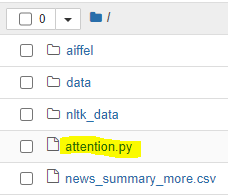

- Attention Mechanism을 설계해 본다. 디코더의 출력층 설계 코드를 아래와 같이 변형할 수 있다.

In [41]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      960000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 3) 모델 훈련 (🔥시간 상당히 많이 소요됩니다.🔥)

- **EarlyStopping이 뭐에요?** (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
- 아래 코드의 두 번째 줄에 주목한다. 여기서 EarlyStopping의 인자로 모니터링 대상을 val_loss로 설정하였다.
- **val_loss는 검증 데이터의 손실을 의미**하는데, 이 값이 줄어들지 않고 증가하는 현상이 2번 연속으로 발생하면 총 epoch와 관계없이 학습을 중도에 멈춘다. (예를 들어 val_loss가 1.2에서 1.21로 늘었다가 다시 1.19가 되면 early stopping 하지 않는다. 연속으로 일어나야 한다!)
- 아래 코드를 돌려보면, 무려 **42번째 epoch에 도달해서야 early stopping의 조건을 만족**하게 됨을 알 수 있었다.
- 조금이라도 빠른 학습을 위해 batch_size를 1024로 조정하고 진행하였다.
- verbose는 얼마나 자세하게 정보를 표시할지를 나타내는 인자이다. (https://cafe.naver.com/masterexcel/1382)

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=1024, callbacks=[es], epochs=50)

Epoch 1/50
58/58 [==============================] - 76s 1s/step - loss: 4.0755 - val_loss: 3.9153
Epoch 2/50
58/58 [==============================] - 64s 1s/step - loss: 3.8978 - val_loss: 3.8093
Epoch 3/50
58/58 [==============================] - 64s 1s/step - loss: 3.7658 - val_loss: 3.6559
Epoch 4/50
58/58 [==============================] - 64s 1s/step - loss: 3.6382 - val_loss: 3.5484
Epoch 5/50
58/58 [==============================] - 64s 1s/step - loss: 3.5102 - val_loss: 3.4619
Epoch 6/50
58/58 [==============================] - 64s 1s/step - loss: 3.4126 - val_loss: 3.3701
Epoch 7/50
58/58 [==============================] - 64s 1s/step - loss: 3.3138 - val_loss: 3.3050
Epoch 8/50
58/58 [==============================] - 64s 1s/step - loss: 3.2381 - val_loss: 3.2266
Epoch 9/50
58/58 [==============================] - 64s 1s/step - loss: 3.1611 - val_loss: 3.1782
Epoch 10/50
58/58 [==============================] - 64s 1s/step - loss: 3.0967 - val_loss: 3.1338
Epoch 11/50
58/58 [

- 지루했던 모델 훈련 과정을 마치고! 👏👏👏
- 이제, 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화하면..?
- 두 손실 모두 일정 값으로 수렴하는 사실을 알 수 있다!

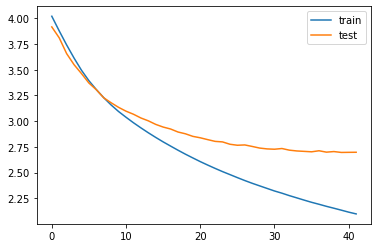

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 📔 5. 인퍼런스 모델 구현하고 테스트하기 (Abstract Summarization) 📔

### 1) 인퍼런스 모델 구현

- 우리는 컴퓨터 상에서 원활한 전처리와 학습, 훈련 등을 위해 정수 인덱싱을 진행하였다.
- 하지만 우리에게 필요한 것은 **정수가 아닌 뉴스기사의 실제 원문과 요약문이다!**
- 따라서 정수 인덱싱 행렬로 존재한 텍스트 데이터를 **실제 데이터로 복원**해주고자 한다.
- 필요한 사전을 미리 준비하자.

In [45]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- seq2seq는 훈련할 때와 실제로 동작할 때의 방식이 달라서 그에 맞게 별도로 모델을 설계해야 한다.
- 이 작업을 위해 인코더 모델과 디코더 모델을 분리 설계한다.

In [46]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

- Attention Mechanism을 사용하는 출력층에 기반하여 디코더 모델을 설계한다.

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

- 실제 동작 단계(인퍼런스 단계)에서 단어 sequence를 완성하는 함수를 설계한다.

In [53]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 2) 모델 테스트

- 아까 전에도 살펴봤듯이 **정수 시퀀스를 텍스트 시퀀스로 변환**해 주어야 우리가 원문과 요약문을 온전히 얻을 수 있음을 알고 있다.
- 따라서 정수 시퀀스를 텍스트 시퀀스로 변환해주는 함수를 다음과 같이 정의한다.

In [54]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

- 이제, Abstractive Summarization의 마지막 단계! 😊😉
- 슬라이싱 기법을 활용하여, 테스트 데이터 몇 개의 샘플에 대하여 실제 요약과 예측된 요약을 비교해본다.

In [60]:
for i in range(0, 25, 2):   # 1번째 데이터부터 24번째 데이터까지 홀수 번째 데이터의 결과만 출력
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : infosys friday said engaging shareholders future course action ensure high governance standards maintained august ceo vishal sikka quit position citing personal attacks infosys blamed co founder narayana murthy murthy also questioned alleged irregularities acquisition pay former executives 
실제 요약 : with on infosys 
예측 요약 :  infosys should be infosys


원문 : government cancelled passports non resident indians wives women child development ministry said eight look issued absconding integrated agency ministry added earlier external affairs minister sushma swaraj said centre would bring bill issue parliament winter session 
실제 요약 : india cancels of for their 
예측 요약 :  govt bans for


원문 : voters switzerland st approved ban facial public swiss first country introduce ban two years ago switzerland hold national referendum issue activists collected one lakh needed trigger referendum 
실제 요약 : second votes to ban in public 
예측 요약 :  australia bans from


원문 : talking bjp observing black day

- **요약 결과를 자세히 살펴보니, 다음과 같은 유형으로 요약이 되었음을 확인할 수 있었다.**
1. 실제 요약과는 다르면서 원문의 내용을 적절히 담아 의미있는 요약을 형성
2. 원문에 없던 단어를 사용해서 요약을 형성
3. 실제 요약에 대해 예측된 요약이 연관성이 떨어지는 경우도 있었음 (**Bad Results👎👎**)

### 3) 기타 성능 개선 방안

- **더 좋은 요약 모델을 만들기 위해서 사용할 수 있는 방법**에는 어떤 것이 있을지 간단히 살펴보자.
- 각 방법별로 더 자세히 알고 싶다면 각 방법별 링크를 읽어보는 것도 도움이 된다!
- 이번 Exploration Project에서는 '이런 것들이 있구나' 정도로만 살펴보고 마무리하겠습니다. 🤞🤞🤞
1. seq2seq와 Attention Mechanism의 조합을 더 좋게 수정
2. **빔 서치(Beam Search)** : https://blog.naver.com/sooftware/221809101199
3. **사전 훈련된 워드 임베딩(pre-trained word embedding)** : https://wikidocs.net/33793
4. **트랜스포머(Transformer)** → 인코더 - 디코더 자체의 구조를 새로이 변경 : http://www.aitimes.com/news/articleView.html?idxno=137202

## 📗 6. Summa를 이용하여 요약하기 (Extractive Summarization) 📗

### 1) 패키지 설치, 데이터 다운로드

- 필수 개념 파트에서, 이전에 **텍스트 요약에는 크게 추출적 요약과 추상적 요약으로 나눌 수 있었음**을 알아보았다.
- 이번에는 Summa를 사용하여 추출적 요약을 수행하는 방법에 대해 알아보도록 한다.
- AIFFEL 클라우드에서는 Summa 패키지가 설치되어 있기 때문에 Cloud Shell에 아래 명령어를 입력해 확인만 해 보겠다.
- 만약 Summa 패키지가 설치되어 있지 않은 환경이라면, 아래 링크를 참조하여 Summa 패키지를 설치한 후 다시 아래 명령어를 입력하면 된다.
(https://pypi.org/project/summa/)

- 필요한 라이브러리를 불러온다.

In [61]:
import requests
from summa.summarizer import summarize

- 매트릭스 시놉시스를 다운로드한다.

In [62]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

- text에는 매트릭스 시놉시스가 문자열로 저장되어 있다.
- 잘 저장되었는지 확인해보기 위해 text 데이터의 일부를 출력해 본다.

In [63]:
print(text[:1000])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and 


### 2) summarize 사용 연습하기

- **Summa의 summarize()의 인자로 사용되는 값들은 다음과 같다. 🤗**
1. **text (문자열)** : 요약할 텍스트
2. **ratio (실수)** : 요약문에서 원본에서 선택되는 문장의 비율. 비율을 나타내므로 ratio는 0과 1사이의 값으로 결정
3. **words (정수 또는 None)** : 출력에 포함할 단어의 수
4. **split (Bool)** : True일 경우 문장의 리스트 / False일 경우 Join된 문자열을 반환

- Summa의 summarize는 **내부적으로 문장 토큰화를 수행**하기 때문에, 원문이 문장 구분이 안 되어 있어도 바로 입력으로 넣을 수 있다.

In [64]:
print('추출적 요약 결과 : ')
print(summarize(text, ratio=0.005))

추출적 요약 결과 : 
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


- **split를 활용**하여 Bool 값에 따른 출력 결과를 확인해보자.
- **split=False** 를 주었을 때의 결과는 방금 위의 코드의 결과와 같음을 알 수 있다.

In [68]:
# split가 True라면?
print('split의 bool 값이 True일 때의 요약결과 : ')
print(summarize(text, ratio=0.005, split=True))

split의 bool 값이 True일 때의 요약결과 : 
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [69]:
# split가 False라면?
print('split의 bool 값이 False일 때의 요약결과 : ')
print(summarize(text, ratio=0.005, split=False))

split의 bool 값이 False일 때의 요약결과 : 
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


- 단어의 수로 요약문의 크기를 조절할 수도 있다!

In [70]:
print('40단어 제한 요약결과 : ')
print(summarize(text, words=40))

40단어 제한 요약결과 : 
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


### 3) summarize 사용하여 뉴스기사 원문 text 추출적 요약하기

- 우선 필요한 파일과 라이브러리를 준비한다.

In [71]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

- 추출적 요약을 위해 Summa의 summarize를 적용한 **exsummary라는 column을 새로 추가**하도록 한다.
- exsummary는 추출적 요약을 나타내는 column 특성이다.

In [72]:
# 아래 코드는 실행 완료까지 다소 시간이 걸릴 수 있습니다!
data['exsummary'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

In [73]:
data.sample(8)

,headlines,text,exsummary
83776,Firm stock jumps 27% after billionaire Buffett...,Canadian lender Home Capital Group's shares so...,Canadian lender Home Capital Group's shares so...
85845,Sports Minister sanctions Ã¢ÂÂ¹200 cr for spo...,Sports Minister Vijay Goel sanctioned Ã¢ÂÂ¹20...,Sports Minister Vijay Goel sanctioned Ã¢ÂÂ¹20...
71999,Yahoo's first CEO to sell his house for $19.4 ...,Yahoo's first CEO Timothy Koogle is selling hi...,Yahoo's first CEO Timothy Koogle is selling hi...
31017,Indian media distorted Sharif's 26/11 remarks:...,Accusing Indian media of distorting remarks ma...,Accusing Indian media of distorting remarks ma...
77502,SC reserves judgement on privacy being a funda...,The Supreme Court's nine-judge Constitutional ...,The Supreme Court's nine-judge Constitutional ...
42617,Data chor BJP macha rahe hain sabse zyada shor...,Taking a dig at BJP over controversy on Facebo...,
42689,Arjuna awardee TT player accused of rape by 18...,An 18-year-old girl has accused 24-year-old Ar...,An 18-year-old girl has accused 24-year-old Ar...
36735,Chadwick should win an Oscar for Black Panther...,'Captain America' actor Chris Evans has said t...,'Captain America' actor Chris Evans has said t...


In [74]:
# 실제 요약과 추출된 요약 비교
for i in range(8):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출 요약 :", data['exsummary'][i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출 요약 : Users get one CRED coin per rupee of bill pai

## 📚 7. 추상적 요약과 추출적 요약의 결과 비교 분석 📚

### 1) 추상적 요약의 결과 (프로젝트 수행 결과 일부 활용)

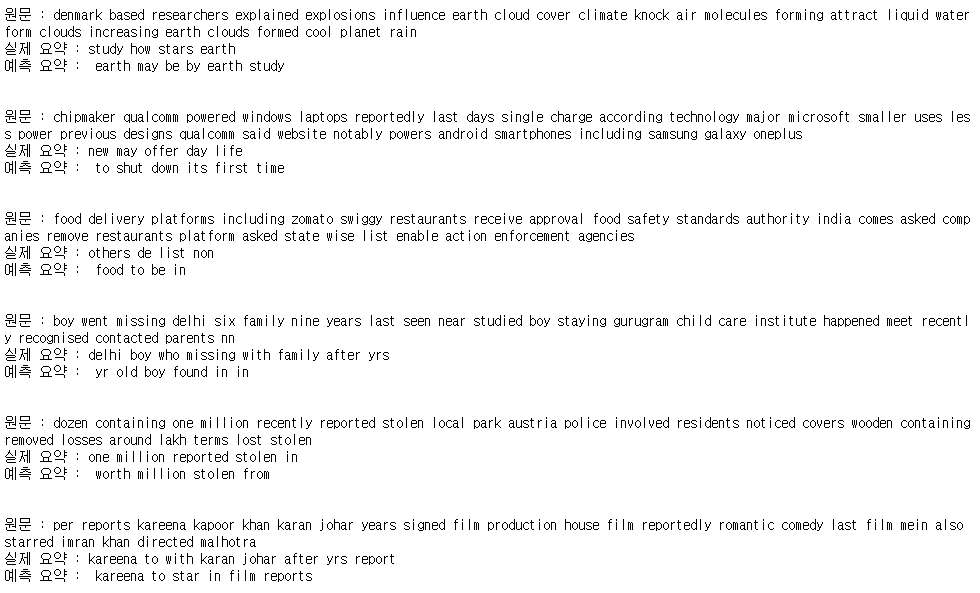

### 2) 추출적 요약의 결과 (프로젝트 수행 결과 일부 활용)

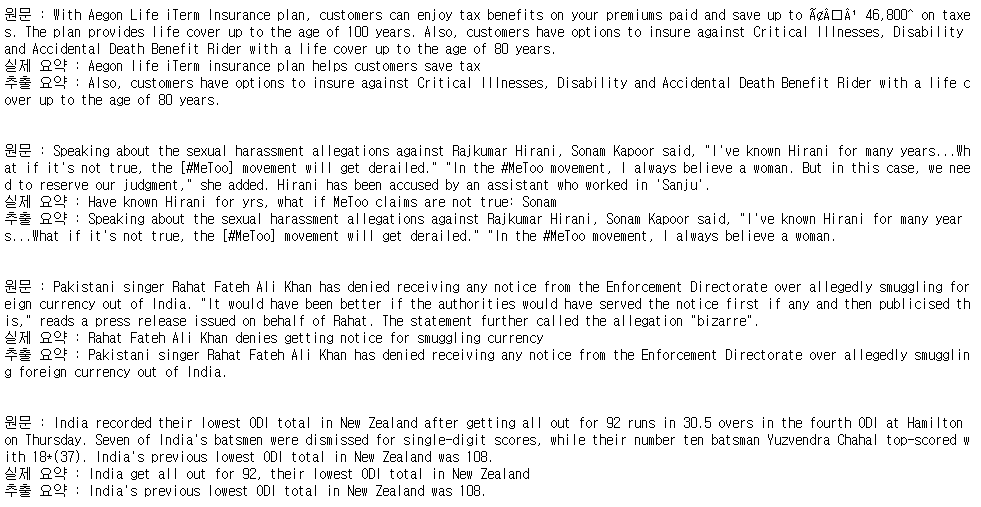

### 3) 결과 비교 분석

|텍스트 요약 방법|처리 과정의 난이도|문법의 완성도|핵심 단어 포함 정도|뉴스기사 요약에서의 적합성|
|------|---|---|---|---|
|<span style="color:red">**추상적 요약(Abstractive Summarization)**</span>|까다롭다|낮다|낮다|대체로 부적합|
|<span style="color:blue">**추출적 요약(Extractive Summarization)**</span>|비교적 쉽다|높다|높다|적합|

- **판단 근거 (처리 과정의 난이도 측면)**
1. **추상적 요약**은 데이터 준비부터 시작해서 분석, 정제, 불용어 제거, 데이터셋 분리, 인코딩 등 여러 과정을 거쳐야 하기에 처리가 매우 어렵다. 다만 이 방법은 추출적 요약과는 달리 원문과 다른 단어를 이용해서 요약하는 등 다양한 요약결과를 얻을 수 있다.
2. **추출적 요약**은 Summa의 summarize를 통해서 원문의 문장 일부를 요약문으로 처리하기 때문에 추상적 요약과는 달리 처리가 쉽다.

- **판단 근거 (문법의 완성도 측면)**
1. **추상적 요약**은 전체적으로 사람들이 요약된 문장을 보고 이해하기에는 문법적으로 부족한 부분들이 꽤 나타났다. **가장 눈에 띄었던 문장은 yr old boy found in in**이었는데, 문법상 in이라는 전치사 다음에 in이라는 전치사가 또 들어가 있으면 문법적으로 이상하게 된다! 😣
2. **추출적 요약**은 대체로 문법적으로 양호한 뉴스기사의 문장들 중에서 한 문장을 그대로 가져오기 때문에 추상적 요약과는 달리 문법적인 완성도가 높은 편이다.

- **판단 근거 (핵심 단어 포함 정도 측면)**
1. **추상적 요약**은 전반적으로 출력된 결과로 미루어 보았을 때, 추출적 요약과는 달리 핵심단어의 비중이 그다지 높지 않았다. 구글에서 번역기를 돌려 확인해 본 결과로는 핵심 단어가 대략 1~2개 정도였다.
2. **추출적 요약**은 원문의 문장들 중에서 그 내용을 가장 잘 표현하는 한 문장을 요약문으로 하기 때문에 추상적 요약에 비해 핵심단어의 비중이 비교적 높은 편이다.

- **판단 근거 (뉴스기사 요약에서의 적합성 측면)**
1. 뉴스기사 요약에서는 추상적 요약은 적합하지 않다고 생각하였다. 요약문을 만들어내기까지의 과정이 복잡하고 문법적인 완성도도 떨어지며 핵심 단어의 비중도 상대적으로 낮기 때문이다.
2. 뉴스는 정확한 사실과 키워드를 기반으로 정보를 전달해 주기 때문에, **뉴스기사에는 추상적 요약보다는 추출적 요약이 더 잘 어울리는 방법이다. 👍**
3. 실제로 네이버 요약봇이 추출적 요약 방법으로 뉴스기사의 내용을 요약한 결과를 제공하고 있다. (https://m.help.naver.com/support/contents/contentsView.help?contentsNo=8125)

## 🟣 8. 탐험을 마치며 🟣

### 1) 내용적 측면에서의 회고
- **<span style="color:deeppink">텍스트 요약 기법인 Abstractive/Extractive Summarization에 대한 구현을 시도해 보았다.</span>** Extractive는 요약할 데이터셋을 불러온 다음 Summa의 summarize 기능을 활용하여 비교적 간단하게 요약을 만들어냈지만 Abstractive는 예측된 요약을 생성하기까지의 과정이 매우 복잡하였다.
- **<span style="color:deeppink">단어 집합의 크기, 단어의 빈도 수, 텍스트 데이터의 최대 길이 등을 어떻게 설정하느냐에 따라 모델의 훈련 결과는 달라질 수 있다.</span>** (하이퍼 파라미터)
- **Abstractive Summarization의 모델을 훈련시키는 데 가장 많은 시간이 소요되었다.** 최대 50 epoch를 반복하는 모델을 훈련하는 과정에서 거의 한 epoch 당 1분 10초 내외의 시간이 소요되었으며 42번째 epoch에서 early stopping이 되면서 대략적으로 50분 정도의 시간이 소요되었다. early stopping을 설정하지 않았다면 훈련에 걸리는 시간은 약 1시간까지 길어졌을 것이다. 이렇듯 이번 프로젝트를 하면서 **<span style="color:deeppink">early stopping이 모델을 훈련시키는 과정에서 중요한 역할을 한다는 것</span>**을 알게 되었다.
- 네이버 요약봇 Beta에 관련한 내용을 읽어보니, 왜 **네이버 요약봇이 뉴스기사를 추출적인 형태로 요약**하는지 이해할 수 있었다. 이것은 뉴스기사의 특성과 관계가 있기 때문일 것이라고 생각하였다.

### 2) 기타 회고

- **<span style="color:deeppink">그렇다면 꼭 뉴스기사만 요약할 수 있을까?</span>** 그렇지는 않을 것이다. 우리 주변에는 수많은 텍스트 데이터가 존재한다. 대표적으로 시, 노래 가사, 소설, 드라마 대본, 영화 대본 등 다양하다.
- **<span style="color:deeppink">그렇다면 이번 프로젝트처럼 영어로 된 것만 요약할 수 있을까?</span>** 그렇지는 않을 것이다. 여기에서는 영어로 된 뉴스기사 데이터에 대해서만 다루어 다른 언어일 경우에는 작업 과정과 내용이 달라질 수 있기 때문에 이 역시도 쉽지 않을 것이라고 생각한다.
- 자연어 처리 분야에 대한 관심이 조금은 더 높아지게 되지 않았나 생각한다. 혹시나 생각해 둔 프로젝트가 있다면 틈틈이 고민해 보고, 무엇을 이루고자 하는지에 대한 그림이 그려질 수 있게 된다면 나중에 좋은 결과물을 낼 수 있지 않을까 생각해 본다! 😋